##  House Prices - Advanced Regression Techniques
- https://www.kaggle.com/code/chazzer/ml-grandmaster-random-forest
- https://towardsdatascience.com/understanding-random-forest-58381e0602d2

<img src="rpics/r10.png" alt="Drawing" style="width: 700px;"/>

<img src="rpics/r11.png" alt="Drawing" style="width: 700px;"/>

<img src="rpics/r12.png" alt="Drawing" style="width: 700px;"/>

<img src="rpics/r13.png" alt="Drawing" style="width: 700px;"/>

## Packages

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data manipulation

from sklearn.ensemble import RandomForestRegressor  # model

from sklearn.tree import DecisionTreeRegressor  # model (used in Building Tree walkthrough)
from matplotlib import pyplot as plt  # visualization
from sklearn.tree import plot_tree  # tree visualization

In [2]:
df = pd.read_csv('data/train.csv')
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
def preprocess(df):
    cols_to_drop = [col for col in df.columns if col not in ['LotArea', 'SalePrice']]
    df['Pool'] = (df['PoolArea'] > 0).astype('int64')
    df['NewConstruction'] = (df['SaleType'] == 'New').astype('int64')
    df['SalePrice'] = df['SalePrice'] // 1000
    df = df.drop(columns=cols_to_drop)
    df = df[['NewConstruction', 'Pool', 'LotArea', 'SalePrice']]
    
    return df

In [4]:
df = df.iloc[[197, 810, 11, 18, 1449], :]
df = preprocess(df)
df

,NewConstruction,Pool,LotArea,SalePrice
197,0,1,25419,235
810,0,1,10140,181
11,1,0,11924,345
18,0,0,13695,159
1449,0,0,1533,92


<img src="rpics/r14.png" alt="Drawing" style="width: 700px;"/>

<img src="rpics/r15.png" alt="Drawing" style="width: 700px;"/>

<img src="rpics/r16.png" alt="Drawing" style="width: 700px;"/>

## BUILDING THE FOREST

In [ ]:
## Let's construct a boostrapped version of our dataset. Let's write some python to assist us with this task.

In [9]:
def bootstrap(df):
    n_rows = df.shape[0]
    random_rows = np.random.randint(n_rows, size=n_rows)
    return df.iloc[random_rows, :]

In [10]:
dfb = bootstrap(df)

In [12]:
## As we can see, our first bootstrapped dataset contains 5 rows, the same as our original dataset, 
## but some rows appear multiple times, like the one with index 1449, which appears three times.
dfb

,NewConstruction,Pool,LotArea,SalePrice
810,0,1,10140,181
197,0,1,25419,235
18,0,0,13695,159
11,1,0,11924,345
18,0,0,13695,159


## Random Feature Selection | Step 1.2

<img src="rpics/r17.png" alt="Drawing" style="width: 800px;"/>

In [13]:
rand_tree = DecisionTreeRegressor(
    criterion="squared_error",
    max_features="sqrt"
)

rand_tree.fit(
    X=dfb.drop(columns=['SalePrice']),
    y=dfb['SalePrice']
)

DecisionTreeRegressor(max_features='sqrt')

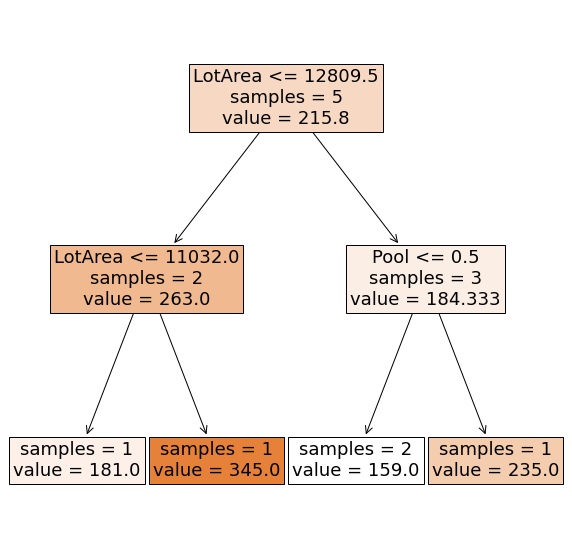

In [14]:
plt.figure(figsize=(10, 10))
plot_tree(
    rand_tree,
    feature_names=['NewConstruction', 'Pool', 'LotArea'],
    filled=True,
    impurity=False,
    fontsize=18
)
plt.show()

<img src="rpics/r18.png" alt="Drawing" style="width: 800px;"/>

In [15]:
random_forest_list = []
random_forest_list.append(rand_tree)  # the tree we above

In [16]:
for i in range(8):
    dfb = bootstrap(df)
    
    rand_tree = DecisionTreeRegressor(
        criterion="squared_error",
        max_features="sqrt"
    )
    
    rand_tree.fit(
        X=dfb.drop(columns=["SalePrice"]),
        y=dfb["SalePrice"]
    )
    
    random_forest_list.append(rand_tree)

In [17]:
def get_grid_coord(k, n):
    return k // n, k % n

/tmp/ipykernel_9871/1528884080.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


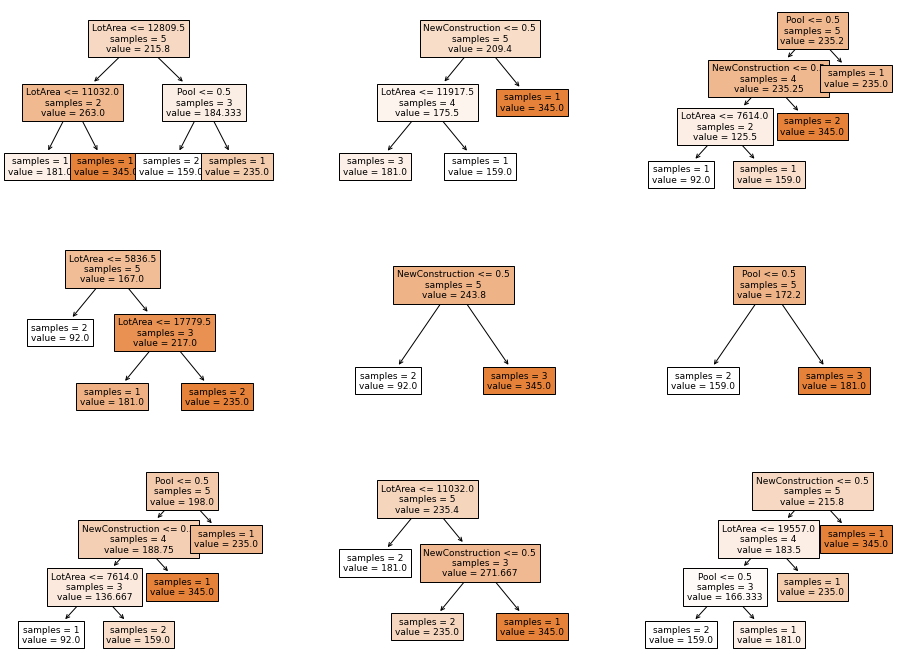

In [18]:
fig, ax = plt.subplots(figsize=(16, 12), nrows=3, ncols=3)
for k in range(9):
    i, j = get_grid_coord(k, 3)
    plot_tree(
        random_forest_list[k],
        feature_names=['NewConstruction', 'Pool', 'LotArea'],
        impurity=False,
        filled=True,
        fontsize=9,
        ax=ax[i][j]
    )

fig.show()

## Aggregating | Step 2

<img src="rpics/r19.png" alt="Drawing" style="width: 700px;"/>

In [19]:
## And with this, the Bagging Algorithm is done and the Random Forest has been built!
inputs = pd.DataFrame([{"NewConstruction": 0, "Pool": 0, "LotArea": 10000}])
prediction = 0
for i, rand_tree in enumerate(random_forest_list):
    prediction += rand_tree.predict(inputs)[0]

prediction /= 9

print(f"Random Forest's predicted Sale Price: {prediction}")

Random Forest's predicted Sale Price: 161.33333333333334


## Code Implementation

<img src="rpics/r20.png" alt="Drawing" style="width: 800px;"/>

In [20]:
# defining our random forest object with the hyper parameters discussed above
model = RandomForestRegressor(
    n_estimators=9,
    criterion="squared_error",
    max_features="sqrt"
)

# Bagging algorithm for building the forest (and CART algorithm for building individual trees)
model.fit(
    X=df.drop(columns=["SalePrice"]),
    y=df["SalePrice"]
)

RandomForestRegressor(max_features='sqrt', n_estimators=9)

In [21]:
def get_grid_coord(k, n):
    return k // n, k % n

/tmp/ipykernel_9871/3771614784.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


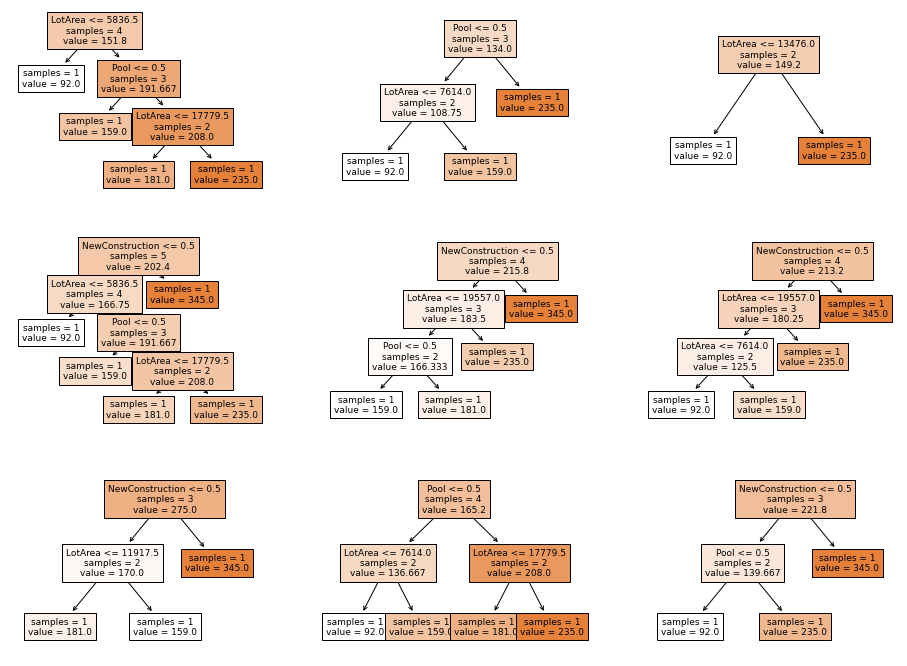

In [22]:
fig, ax = plt.subplots(figsize=(16, 12), nrows=3, ncols=3)

# to access the individual trees in the random forest, we use the estimators_ attribute
for k, rand_tree in enumerate(model.estimators_):
    i, j = get_grid_coord(k, 3)
    plot_tree(
        rand_tree,
        feature_names=['NewConstruction', 'Pool', 'LotArea'],
        impurity=False,
        filled=True,
        fontsize=9,
        ax=ax[i][j]
    )

fig.show()

In [ ]:
## So now, let's predict the SalePrice of a house with the following characteristics.
## NewConstruction = 0, Pool = 0, LotArea = 10000.

In [23]:
inputs = pd.DataFrame([{"NewConstruction": 0, "Pool": 0, "LotArea": 10000}])
prediction = model.predict(inputs)
print(f"Random Forest's predicted Sale Price: {prediction}")

Random Forest's predicted Sale Price: [146.55555556]


In [ ]:
<img src="rpics/r10.png" alt="Drawing" style="width: 700px;"/>

In [ ]:
<img src="rpics/r10.png" alt="Drawing" style="width: 700px;"/>

In [ ]:
<img src="rpics/r10.png" alt="Drawing" style="width: 700px;"/>